In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from gpflow.utilities import print_summary, set_trainable, to_default_float
import gpflow
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions

import os
os.environ["CUDA_VISIBLE_DEVICES"] = '5'

from sklearn.metrics import mean_squared_error, mean_absolute_error
from properscoring import crps_gaussian

import sys
sys.path.append('../../src')
from data_preparation import get_birth_data, separate_data
from useful_fun import plot_distribution, percentage_outof_CI, number_outof_CI

In [2]:
# load data

# whole dataset
data = get_birth_data()
x, y = separate_data(data, train_test=False)

# train/test split
df_train = pd.read_csv('../../data/train.csv')
x_train, y_train = separate_data(df_train)
df_test = pd.read_csv('../../data/test.csv')
x_test, y_test = separate_data(df_test)

# get date for x-axis in plots
def get_xticks(data):
    idss = []; yrs = []
    yr = 1969
    for i in range(20):
        df = data.loc[data.year == yr+i]
        yrs.append(yr+i)
        idss.append(df.index[0])
    return idss, yrs
pos, labels = get_xticks(data)

2022-08-22 12:54:38.150899: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-22 12:54:38.774188: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9646 MB memory:  -> device: 0, name: GeForce RTX 2080 Ti, pci bus id: 0000:b2:00.0, compute capability: 7.5


# Simple one-latent function model

        y = f(x) + e
        f = GP(0, RBF)

        l = InvGama()
        sigma = Gamma()

# Train / Test split: model selection

Assess which kernel helps represent the data best.

    MSE, MAE, Likelihood

Since we have found that the starting point of kernel parameters affects the fit significantly, we will first select the kernel and then run an analysis to find optimal starting conditions for hyperparameters.

In [3]:
def optimise_predict_model(model, epochs=50, alpha=0.01):
    train_data = (x_train, y_train)
    loss_fn = model.training_loss_closure(train_data) 

    gpflow.utilities.set_trainable(model.q_mu, False)
    gpflow.utilities.set_trainable(model.q_sqrt, False)

    variational_vars = [(model.q_mu, model.q_sqrt)]
    natgrad_opt = gpflow.optimizers.NaturalGradient(gamma=0.1)
    adam_vars = model.trainable_variables
    adam_opt = tf.optimizers.Adam(alpha)

    @tf.function
    def optimisation_step():
        natgrad_opt.minimize(loss_fn, variational_vars)
        adam_opt.minimize(loss_fn, adam_vars)

    for epoch in range(1, epochs + 1):
        optimisation_step()

    # fitted values
    mean_train, var_train = model.predict_y(x_train)
    print('Train')
    plot_distribution(x_train, y_train, mean_train, var_train, pos, labels, legend=False)

    # predict
    mean_test, var_test = model.predict_y(x_test)
    print('Test')
    plot_distribution(x_test, y_test, mean_test, var_test, pos, labels)

    print('train ELBO, MSE, MAE: ', model.elbo((x_train,y_train)).numpy(), mean_squared_error(y_train, mean_train), mean_absolute_error(y_train, mean_train))
    print('test ELBO, MSE, MAE: ', model.elbo((x_test,y_test)).numpy(), mean_squared_error(y_test, mean_test), mean_absolute_error(y_test, mean_test))
    print('percentage out of CI (train, test): ', percentage_outof_CI(y_train, mean_train, var_train), percentage_outof_CI(y_test, mean_test, var_test))
    print('number out of CI (train, test): ', number_outof_CI(y_train, mean_train, var_train), number_outof_CI(y_test, mean_test, var_test))
    print('Avg. CRPS (train, test): ', np.mean(crps_gaussian(y_train, mean_train, np.sqrt(var_train))), np.mean(crps_gaussian(y_test, mean_test, np.sqrt(var_test))))


    print_summary(model, fmt='notebook')

2022-08-22 12:56:39.430224: I tensorflow/core/util/cuda_solvers.cc:179] Creating GpuSolver handles for stream 0x83222b0


Train


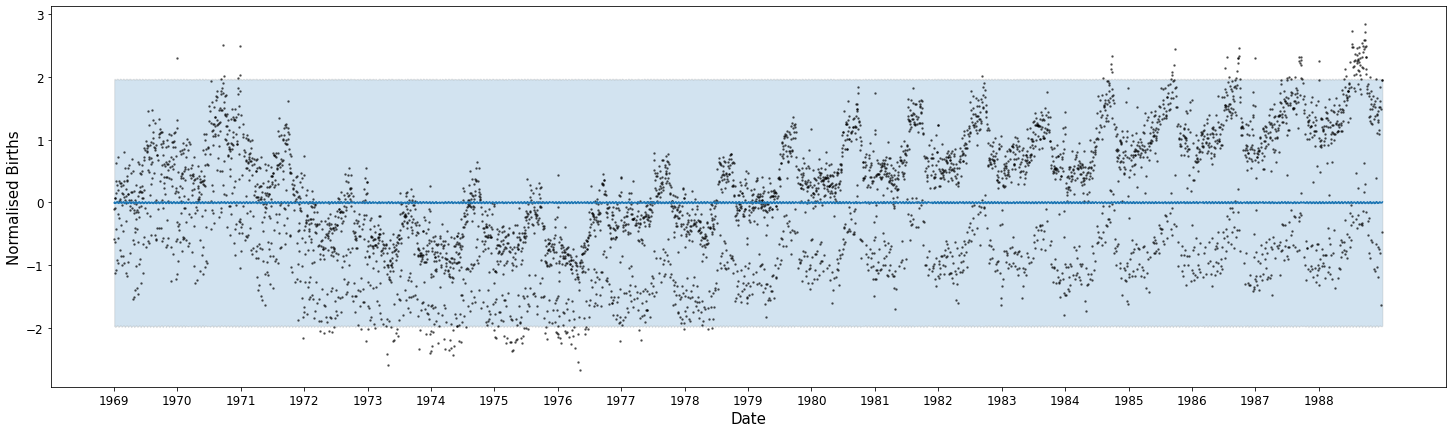

Test


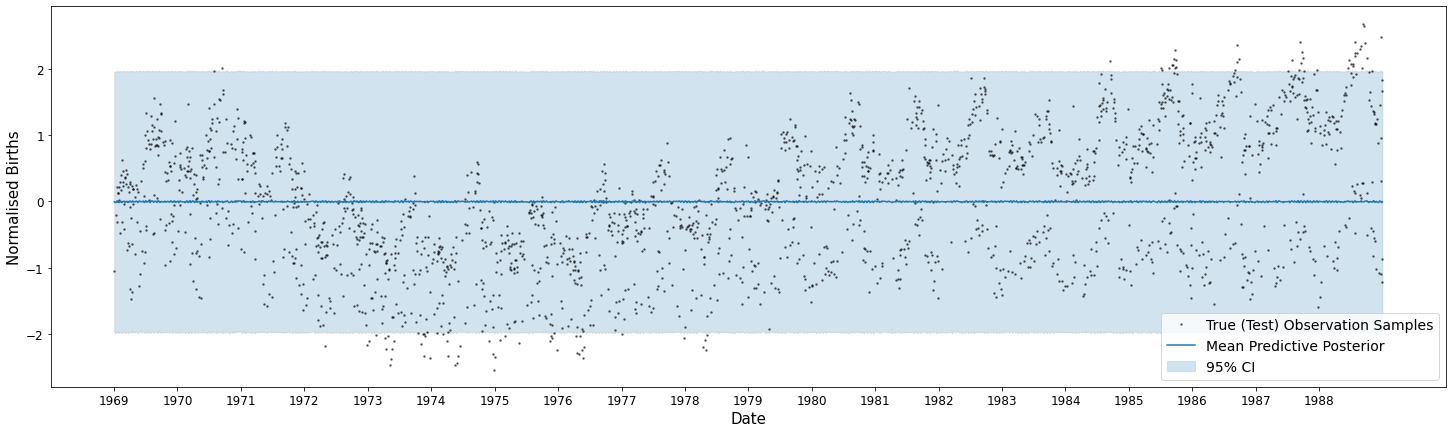

train ELBO, MSE, MAE:  -4272.485006218999 0.9999596053183376 0.8367599476500305
test ELBO, MSE, MAE:  -4320.875750566213 1.0322205337060024 0.8545824939528623
percentage out of CI (train, test):  3.5595540778407977 4.37956204379562
number out of CI (train, test):  182 96
Avg. CRPS (train, test):  0.5738150653332453 0.5840215592452418


--------------------------------------------------------
Train


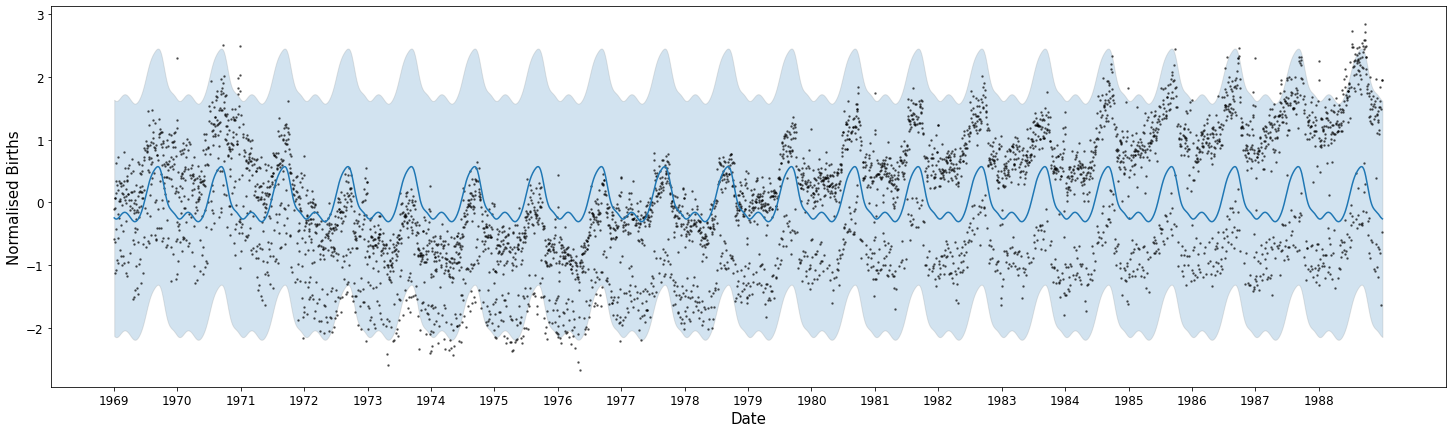

Test


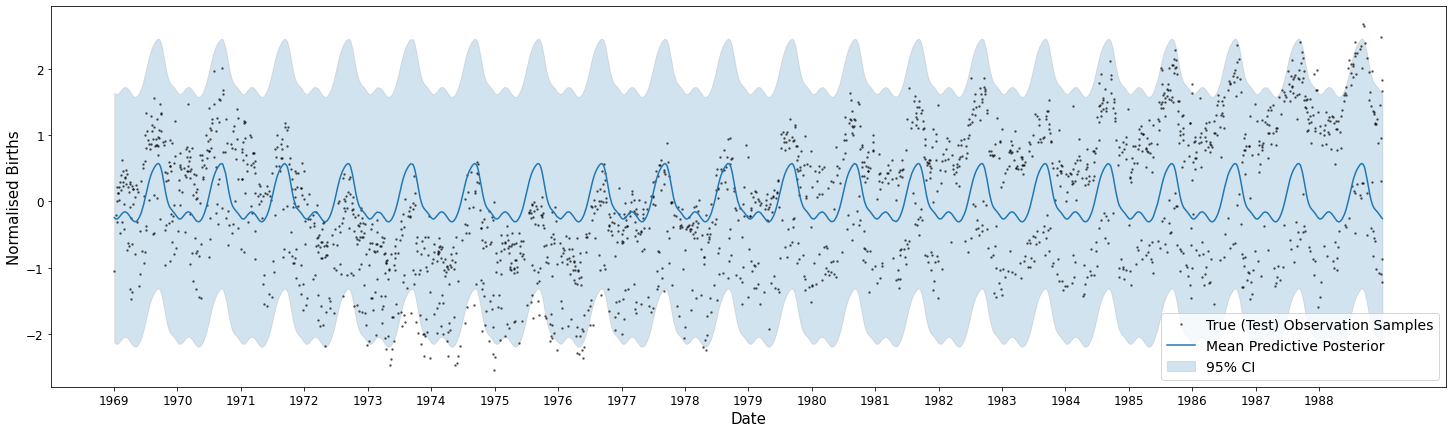

train ELBO, MSE, MAE:  -4135.430217512057 0.9101291900672845 0.8153121507576708
test ELBO, MSE, MAE:  -4162.478502881217 0.9266539073453643 0.8269057545224767
percentage out of CI (train, test):  3.2661842362605125 3.102189781021898
number out of CI (train, test):  167 68
Avg. CRPS (train, test):  0.5497798665250211 0.5556979977010044


--------------------------------------------------------
Train


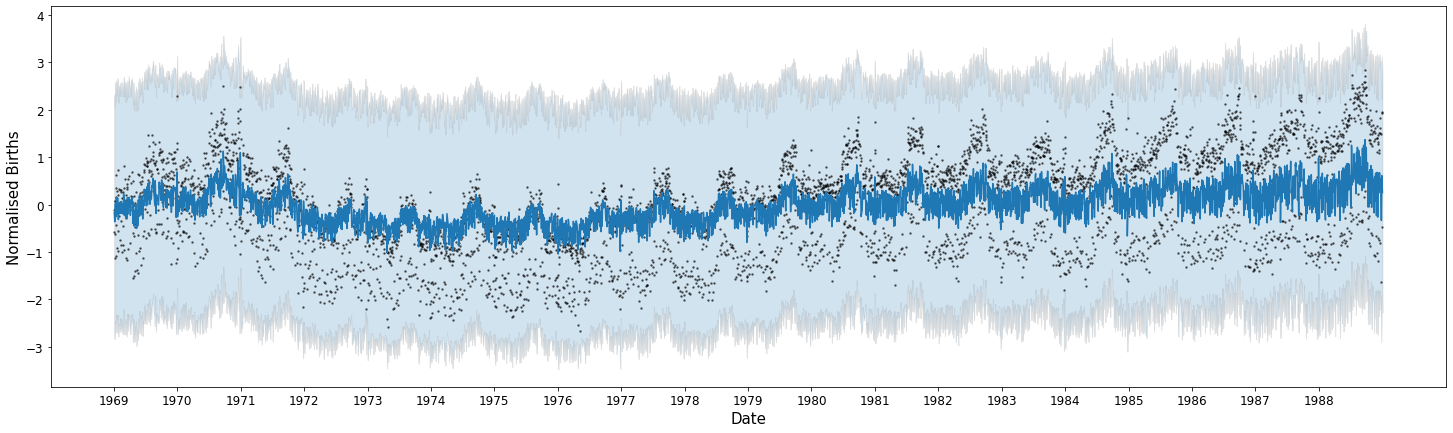

Test


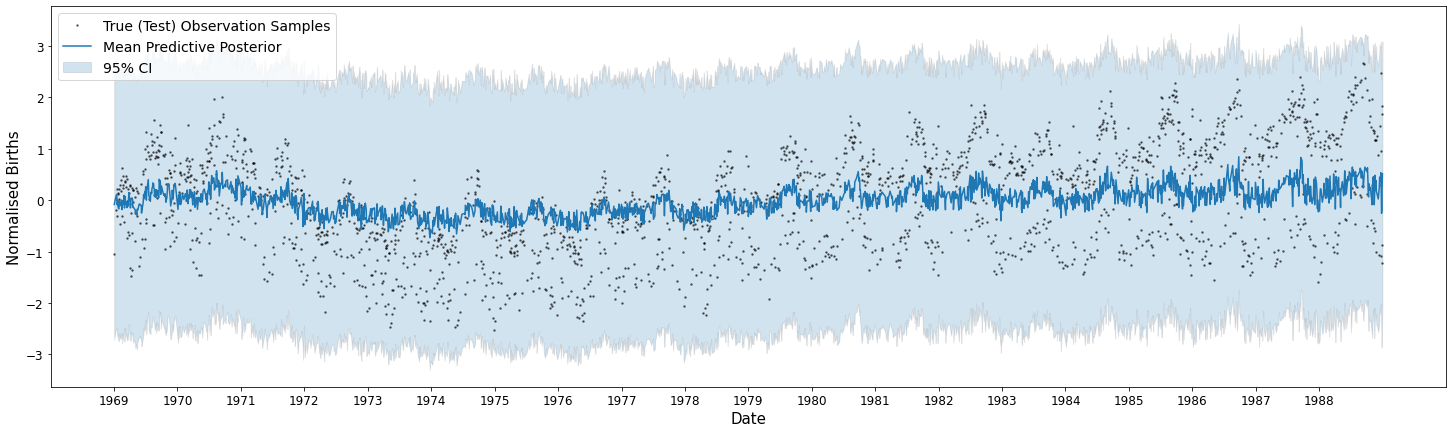

train ELBO, MSE, MAE:  -4630.032457315715 0.4519965419090677 0.564746944769302
test ELBO, MSE, MAE:  -5210.000838202964 0.7660423073896829 0.7398217143559926
percentage out of CI (train, test):  0.0 0.0
number out of CI (train, test):  0 0
Avg. CRPS (train, test):  0.43367759551738166 0.5238882994913299


--------------------------------------------------------
Train


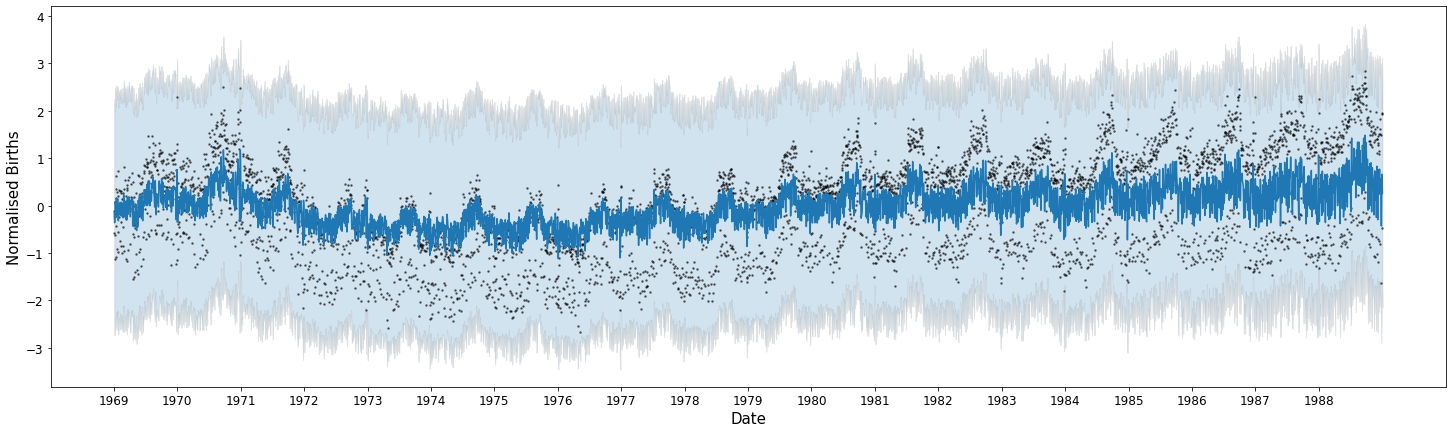

Test


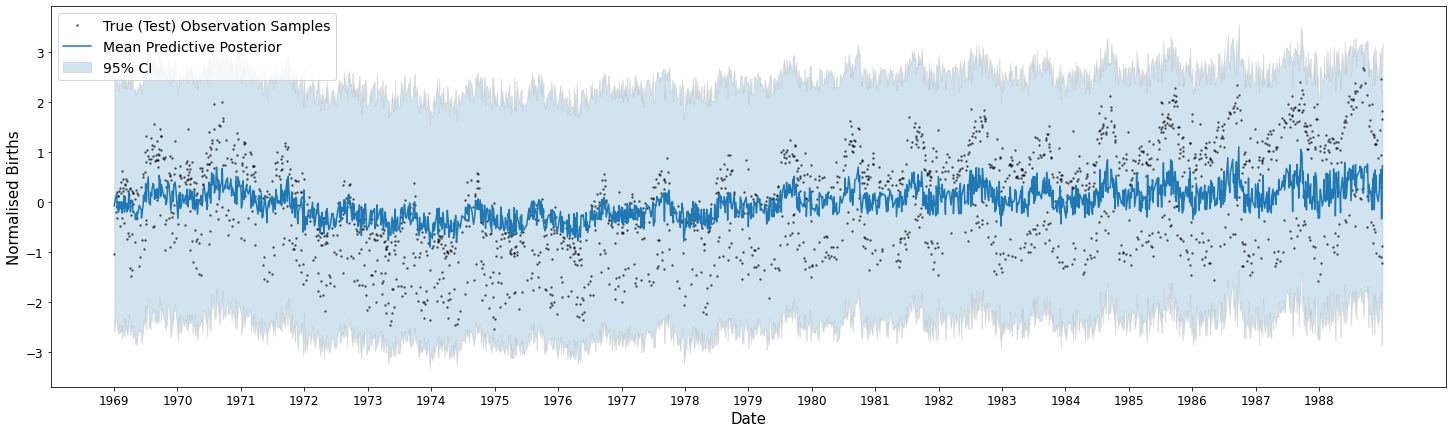

train ELBO, MSE, MAE:  -4524.9247817256455 0.4093529213900756 0.5342839601979805
test ELBO, MSE, MAE:  -5172.465835190262 0.7257874873480789 0.7181760376358557
percentage out of CI (train, test):  0.0 0.0
number out of CI (train, test):  0 0
Avg. CRPS (train, test):  0.41281889572316455 0.5080969656213316


--------------------------------------------------------


In [7]:
# Kernel MODEL SELECTION
kernel_list = [gpflow.kernels.Periodic(gpflow.kernels.Matern52()), gpflow.kernels.Periodic(gpflow.kernels.Matern52(), period=365.25), gpflow.kernels.Matern32(), gpflow.kernels.RBF()]

M = 3000

for i in range(len(kernel_list)):
    print(kernel_list[i])
    kernel = kernel_list[i]

    Z = np.linspace(x_train.numpy().min(), x_train.numpy().max(), M)[:, None]
    model = gpflow.models.SVGP(kernel, gpflow.likelihoods.Gaussian(), Z, mean_function=gpflow.mean_functions.Zero(), num_data=M)
    set_trainable(model.likelihood.variance, True)
    model.likelihood.variance.prior = tfp.distributions.Normal(to_default_float(0), to_default_float(1))

    if i in [0,1]:
        model.kernel.period.prior = tfp.distributions.Uniform(to_default_float(0), to_default_float(1))
        model.kernel.base_kernel.lengthscales.prior = tfp.distributions.InverseGamma(to_default_float(1), to_default_float(1))
        model.kernel.base_kernel.variance.prior = tfp.distributions.Gamma(to_default_float(1), to_default_float(1))
    else:
        model.kernel.lengthscales.prior = tfp.distributions.InverseGamma(to_default_float(1), to_default_float(1))
        model.kernel.variance.prior = tfp.distributions.Gamma(to_default_float(1), to_default_float(1))
    
    optimise_predict_model(model)
    print('--------------------------------------------------------')

The kernel with best performance: RBF. Although, Matern52 performs similar. BUT, the models seem to be overfitting. Maybe lower the epochs...

Now, we would carry out the sensitivity analysis done before but on the train test set.

Starting Values l:  1
Train


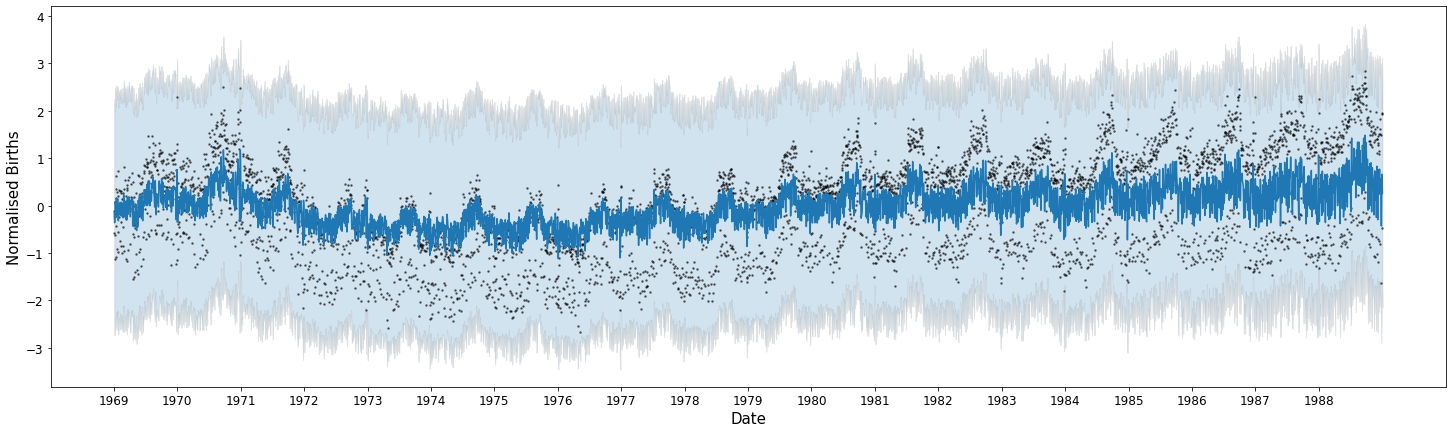

Test


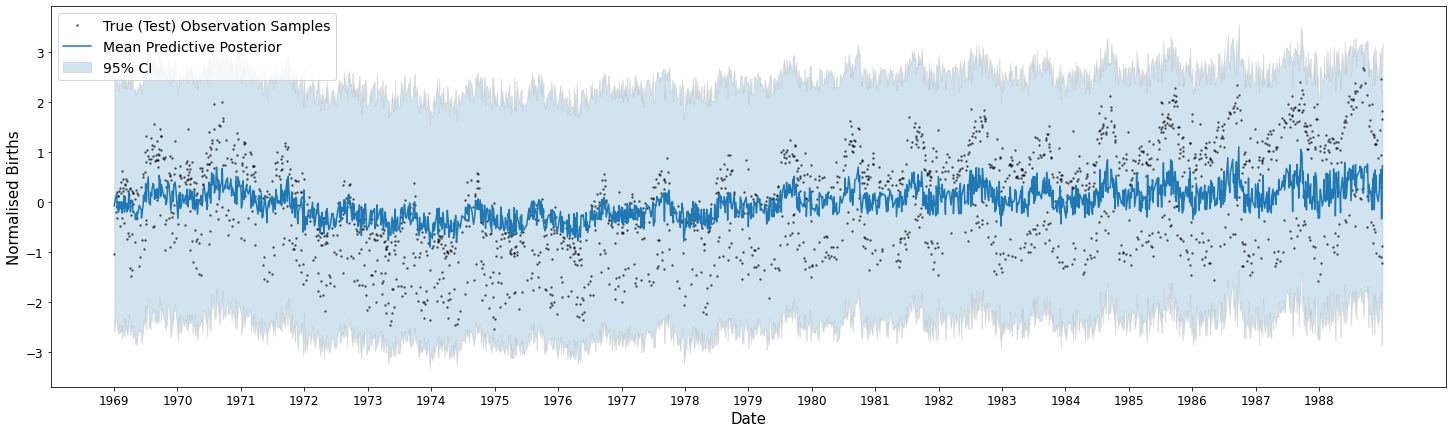

train ELBO, MSE, MAE:  -4524.9247817256455 0.4093529213900756 0.5342839601979805
test ELBO, MSE, MAE:  -5172.465835190262 0.7257874873480789 0.7181760376358557
percentage out of CI (train, test):  0.0 0.0
number out of CI (train, test):  0 0
Avg. CRPS (train, test):  0.41281889572316455 0.5080969656213316


--------------------------------------------------------
Starting Values l:  77
Train


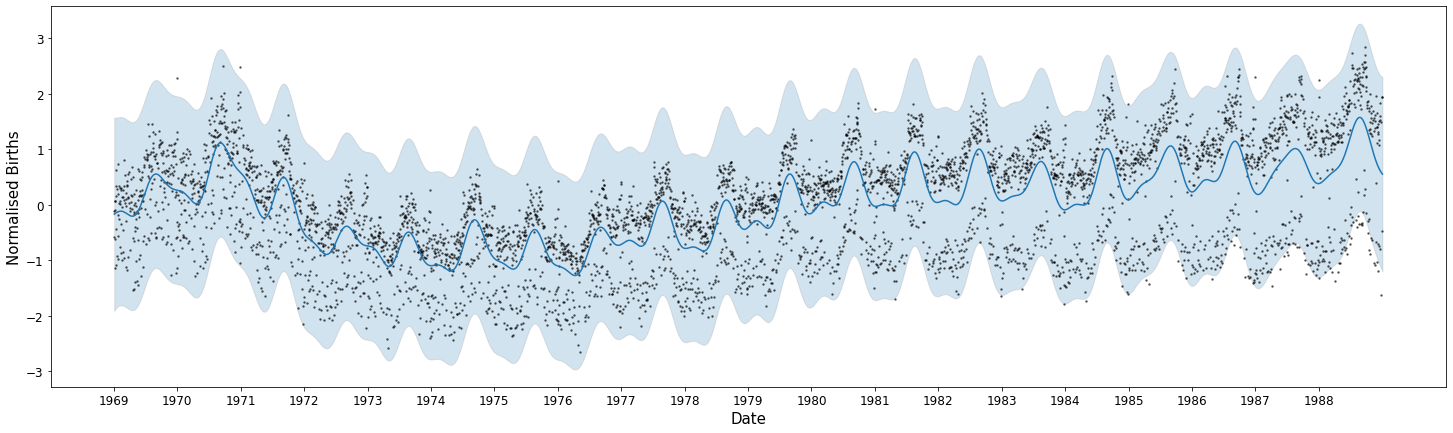

Test


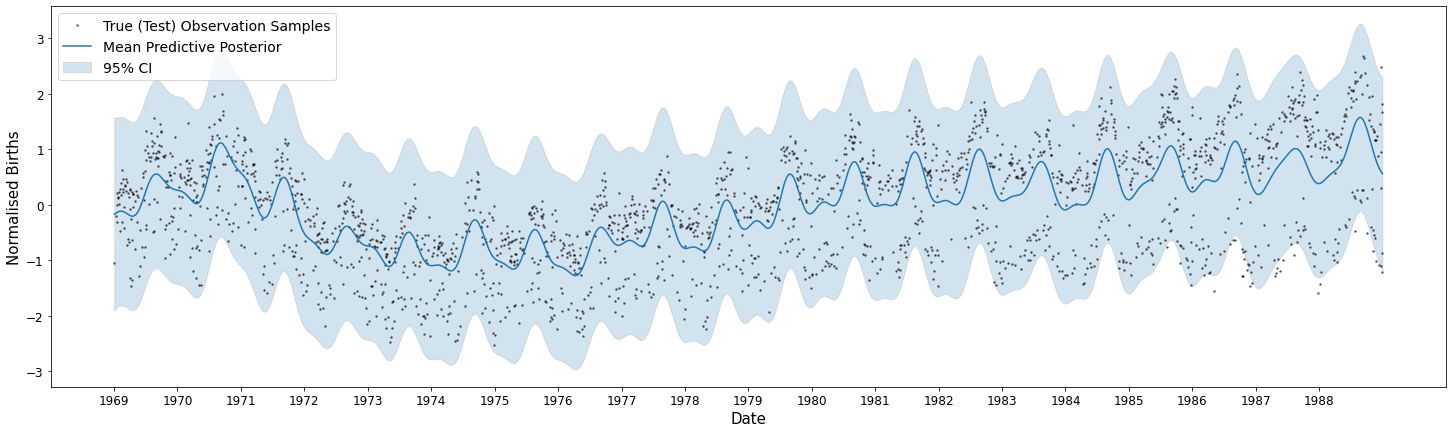

train ELBO, MSE, MAE:  -3584.6450162403453 0.5534534770902181 0.6263982202973158
test ELBO, MSE, MAE:  -3655.881037874915 0.5872881585000624 0.6449592479762545
percentage out of CI (train, test):  1.2908273029532564 1.3686131386861315
number out of CI (train, test):  66 30
Avg. CRPS (train, test):  0.427224637060136 0.4397958549600346


--------------------------------------------------------
Starting Values l:  200
Train


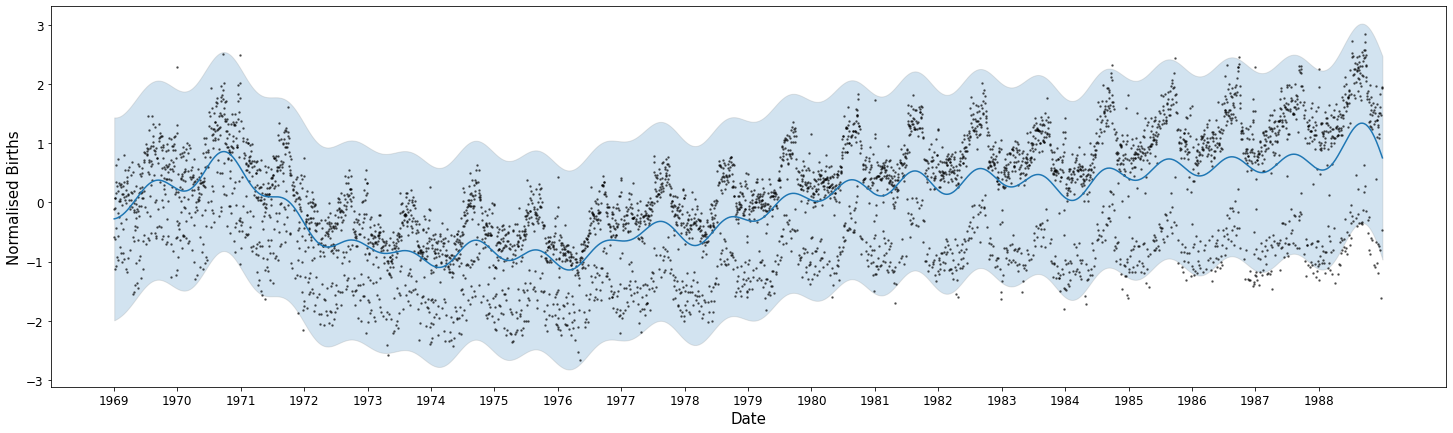

Test


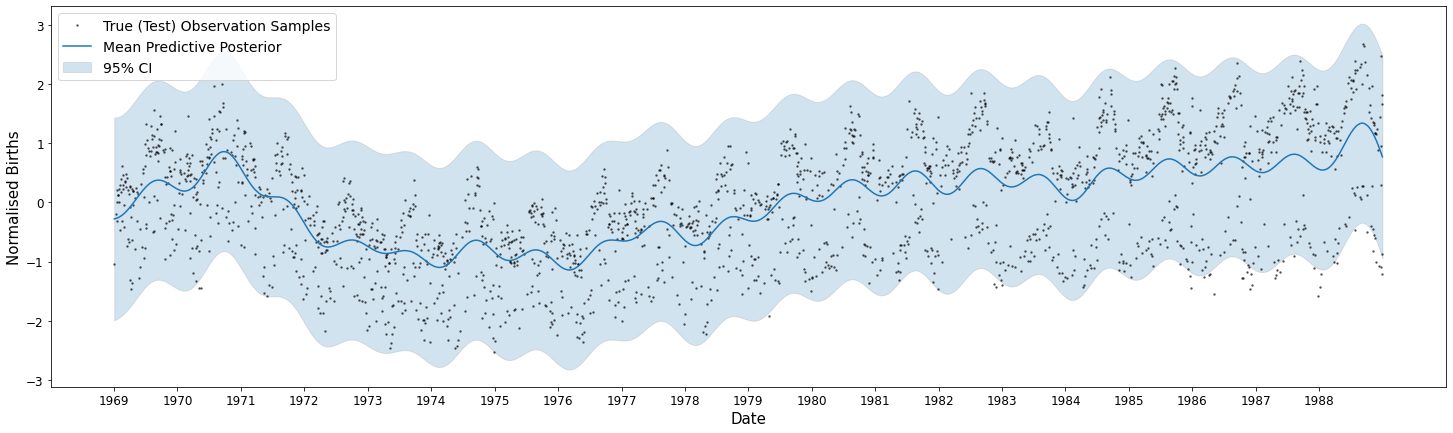

train ELBO, MSE, MAE:  -3631.4333677364802 0.6002551220965783 0.6403945599500495
test ELBO, MSE, MAE:  -3692.653823659569 0.6298032894665896 0.6560310356484732
percentage out of CI (train, test):  1.916682964991199 1.8704379562043798
number out of CI (train, test):  98 41
Avg. CRPS (train, test):  0.44317860910927387 0.45450289996846777


--------------------------------------------------------


In [5]:
starting_values_l = [1, 77, 200]
M = 3000

for l in starting_values_l:
    print('Starting Values l: ', l)
    kernel = gpflow.kernels.RBF(lengthscales = l, variance = 1)
    Z = np.linspace(x_train.numpy().min(), x_train.numpy().max(), M)[:, None]
    model = gpflow.models.SVGP(kernel, gpflow.likelihoods.Gaussian(), Z, mean_function=gpflow.mean_functions.Zero(), num_data=M)
    
    set_trainable(model.likelihood.variance, True)
    model.likelihood.variance.prior = tfp.distributions.Normal(to_default_float(0), to_default_float(1))
    model.kernel.lengthscales.prior = tfp.distributions.InverseGamma(to_default_float(1), to_default_float(1))
    model.kernel.variance.prior = tfp.distributions.Gamma(to_default_float(1), to_default_float(1))

    optimise_predict_model(model)
    print('--------------------------------------------------------')

Starting Values v:  0.3
Train


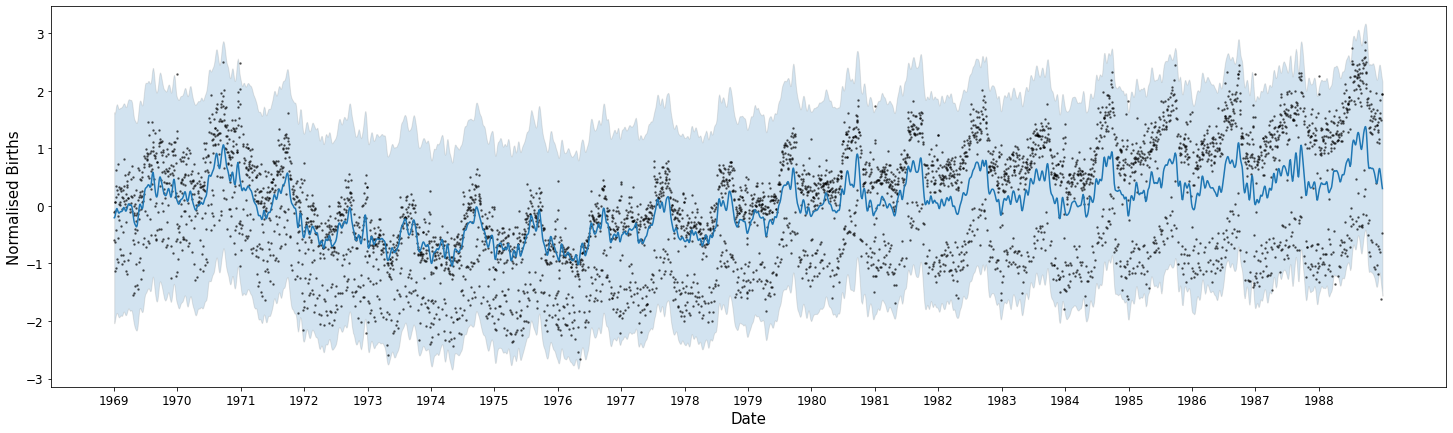

Test


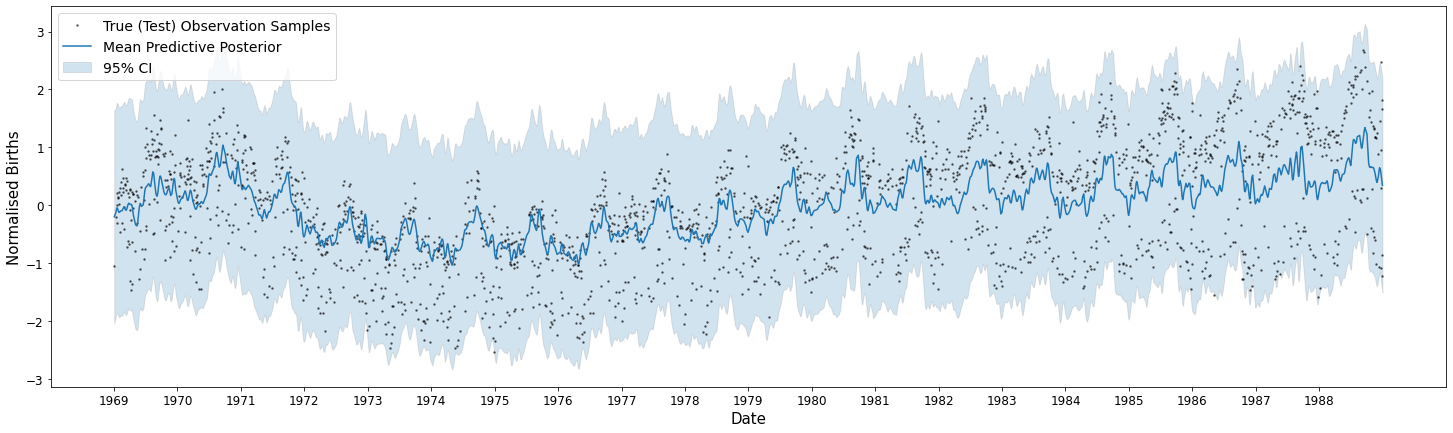

train ELBO, MSE, MAE:  -3932.988964665178 0.5614648075358294 0.6287768993854843
test ELBO, MSE, MAE:  -4155.044666118556 0.6641007678178112 0.6864418628512289
percentage out of CI (train, test):  0.2542538627029141 0.41058394160583944
number out of CI (train, test):  13 9
Avg. CRPS (train, test):  0.43396130825936613 0.47048514554582443


--------------------------------------------------------
Starting Values v:  0.5
Train


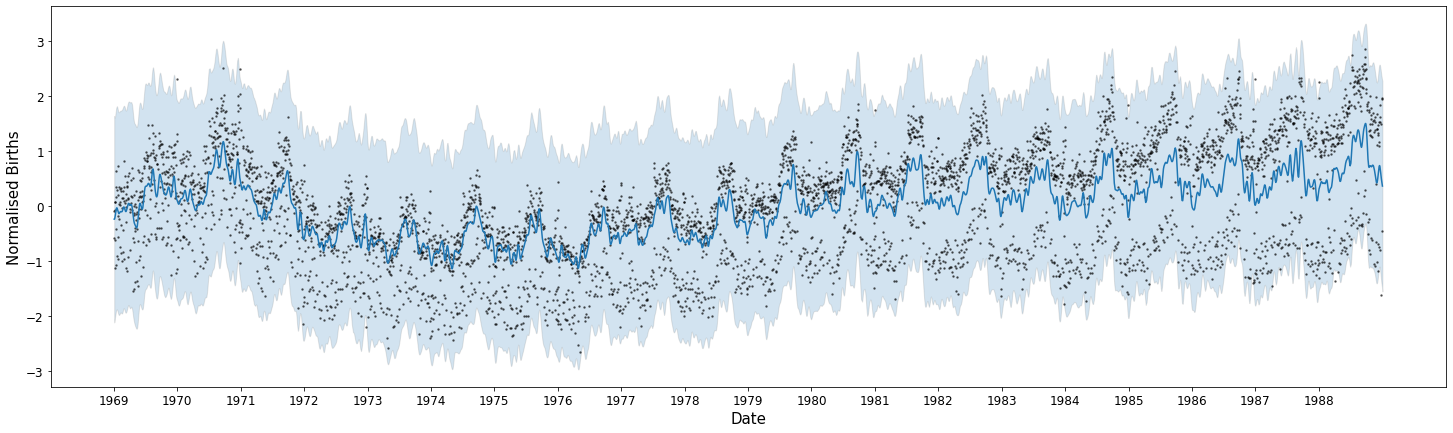

Test


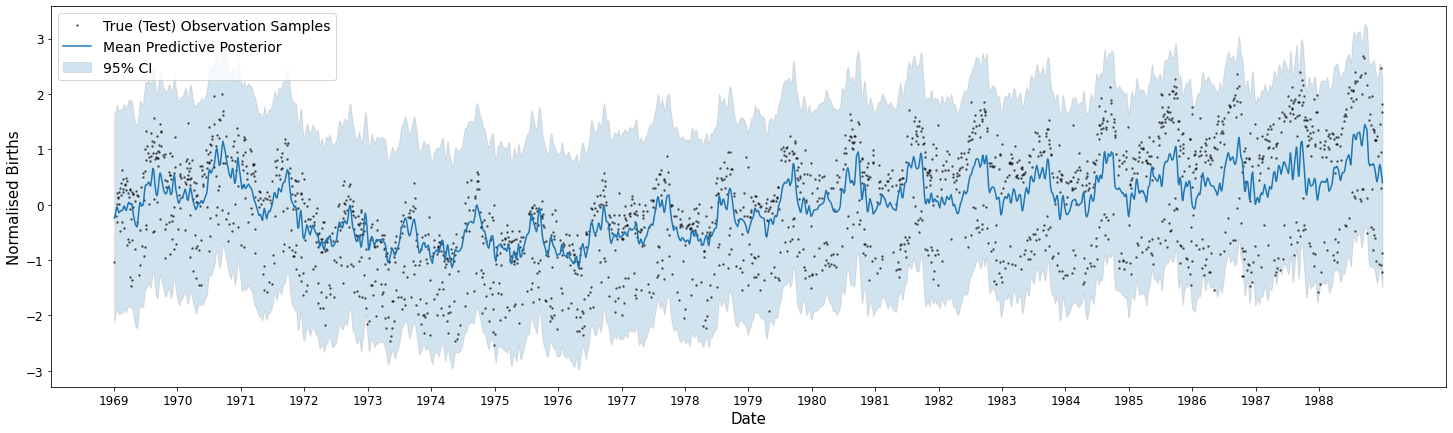

train ELBO, MSE, MAE:  -3948.3330560490513 0.5425759530914823 0.618320873350949
test ELBO, MSE, MAE:  -4199.509808441103 0.6580465965798606 0.6832818246502391
percentage out of CI (train, test):  0.21513788382554275 0.3193430656934307
number out of CI (train, test):  11 7
Avg. CRPS (train, test):  0.427635147149156 0.4683749527048448


--------------------------------------------------------
Starting Values v:  1
Train


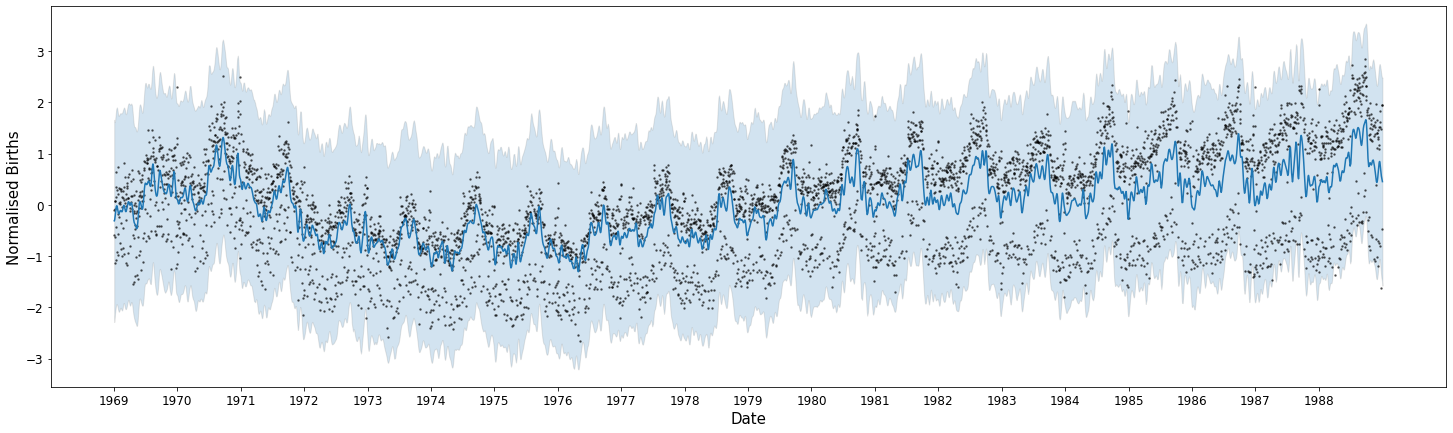

Test


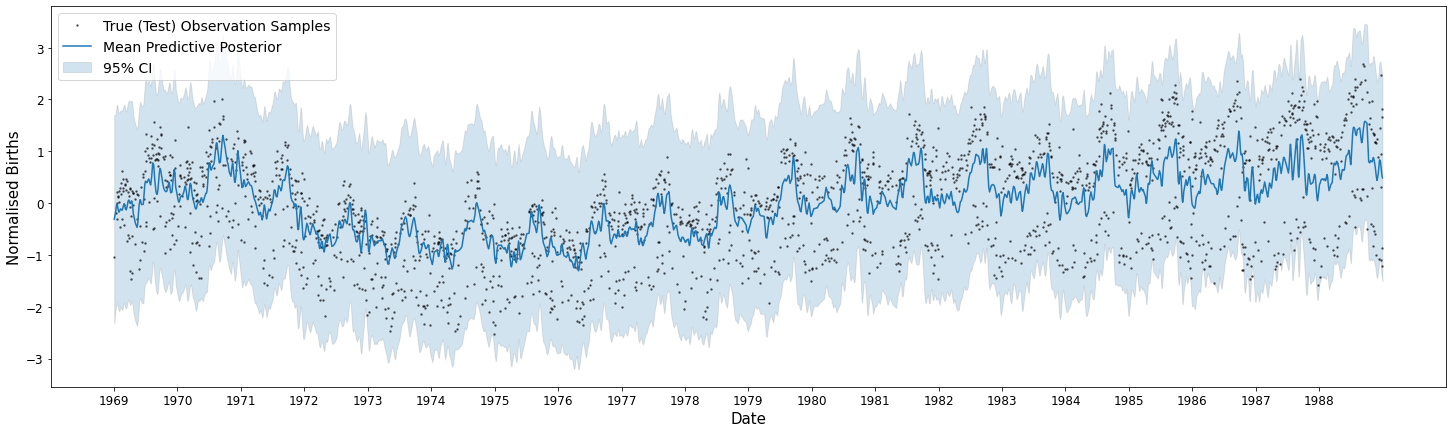

train ELBO, MSE, MAE:  -4045.610800700285 0.522276262657626 0.6068363469711624
test ELBO, MSE, MAE:  -4350.628768700853 0.6630641916366353 0.6860130294101394
percentage out of CI (train, test):  0.17602190494817133 0.2737226277372263
number out of CI (train, test):  9 6
Avg. CRPS (train, test):  0.42189564743132474 0.4703719407893198


--------------------------------------------------------
Starting Values v:  2
Train


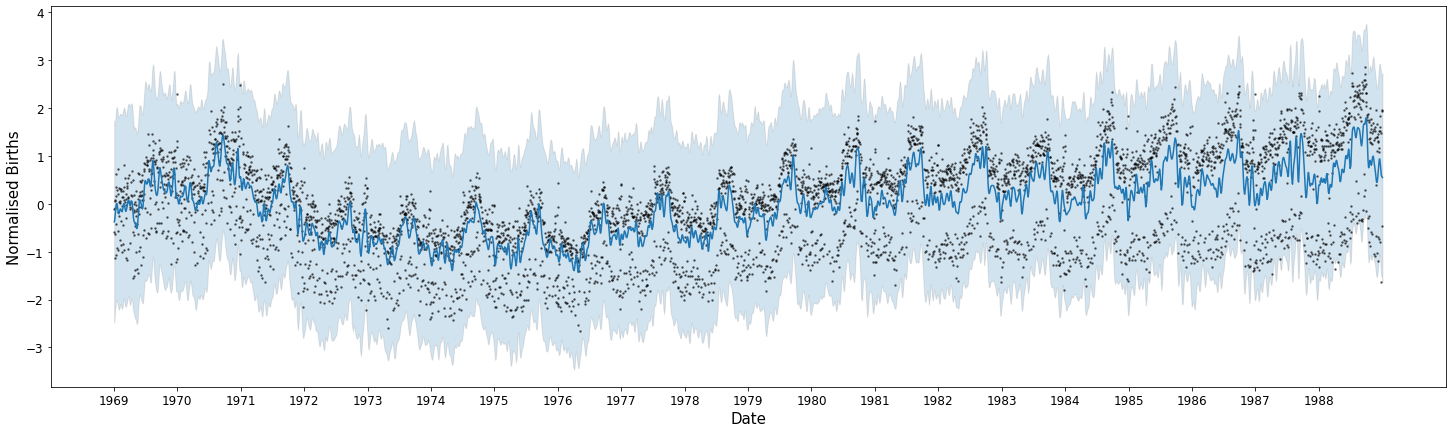

Test


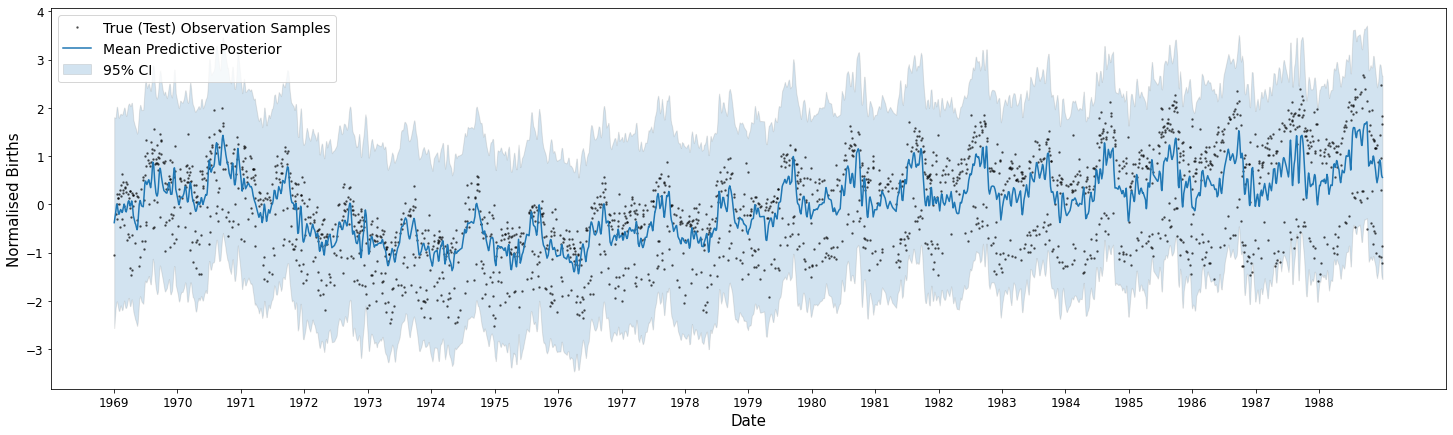

train ELBO, MSE, MAE:  -4240.415153202947 0.5110845475569834 0.5996241925073099
test ELBO, MSE, MAE:  -4599.682165028692 0.6810669704200037 0.6946930731738137
percentage out of CI (train, test):  0.11734793663211421 0.36496350364963503
number out of CI (train, test):  6 8
Avg. CRPS (train, test):  0.4209743364501105 0.47756211788287445


--------------------------------------------------------


In [6]:
starting_values_v = [0.3, 0.5, 1, 2]
M = 3000

for v in starting_values_v:
    print('Starting Values v: ', v)
    kernel = gpflow.kernels.RBF(lengthscales = 7, variance = v)
    Z = np.linspace(x_train.numpy().min(), x_train.numpy().max(), M)[:, None]
    model = gpflow.models.SVGP(kernel, gpflow.likelihoods.Gaussian(), Z, mean_function=gpflow.mean_functions.Zero(), num_data=M)
    set_trainable(model.likelihood.variance, True)

    model.likelihood.variance.prior = tfp.distributions.Normal(to_default_float(0), to_default_float(1))
    model.kernel.lengthscales.prior = tfp.distributions.InverseGamma(to_default_float(1), to_default_float(1))
    model.kernel.variance.prior = tfp.distributions.Gamma(to_default_float(1), to_default_float(1))

    optimise_predict_model(model)
    print('--------------------------------------------------------')

Much larger ls

Starting Values l:  30
Train


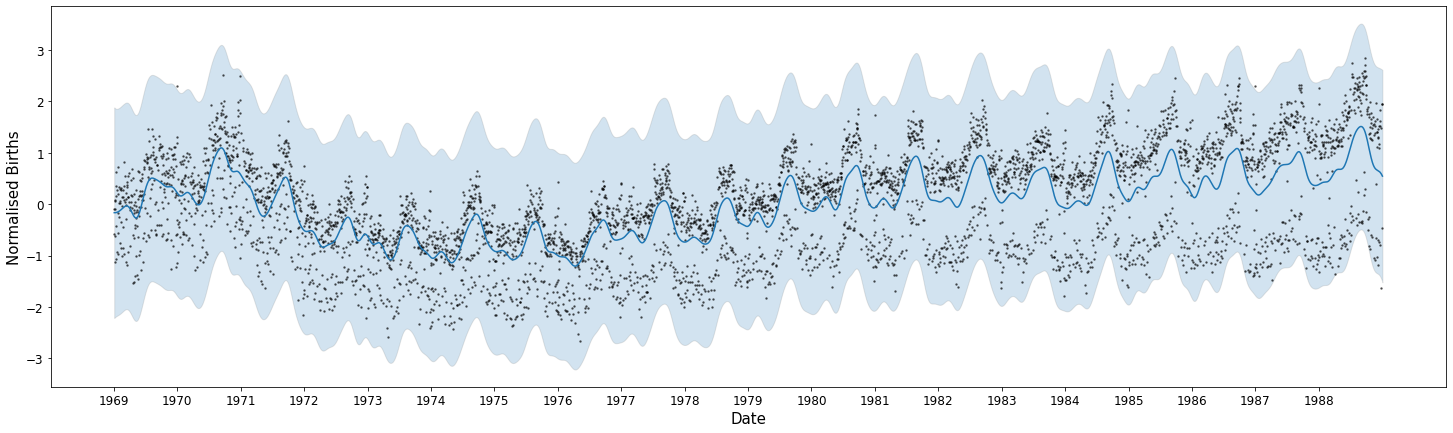

Test


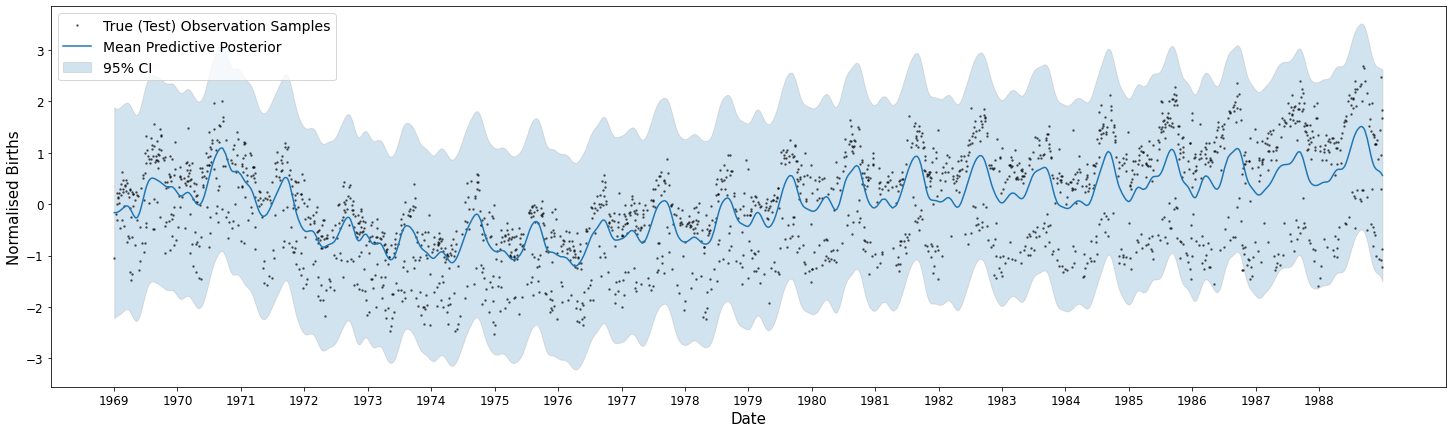

train ELBO, MSE, MAE:  -3790.8311217069718 0.5512321152216821 0.6260516032749283
test ELBO, MSE, MAE:  -3856.0443141985675 0.5932422251571309 0.6484445713539495
percentage out of CI (train, test):  0.058673968316057104 0.09124087591240876
number out of CI (train, test):  3 2
Avg. CRPS (train, test):  0.43541687770006937 0.44936687739082093


--------------------------------------------------------
Starting Values l:  50
Train


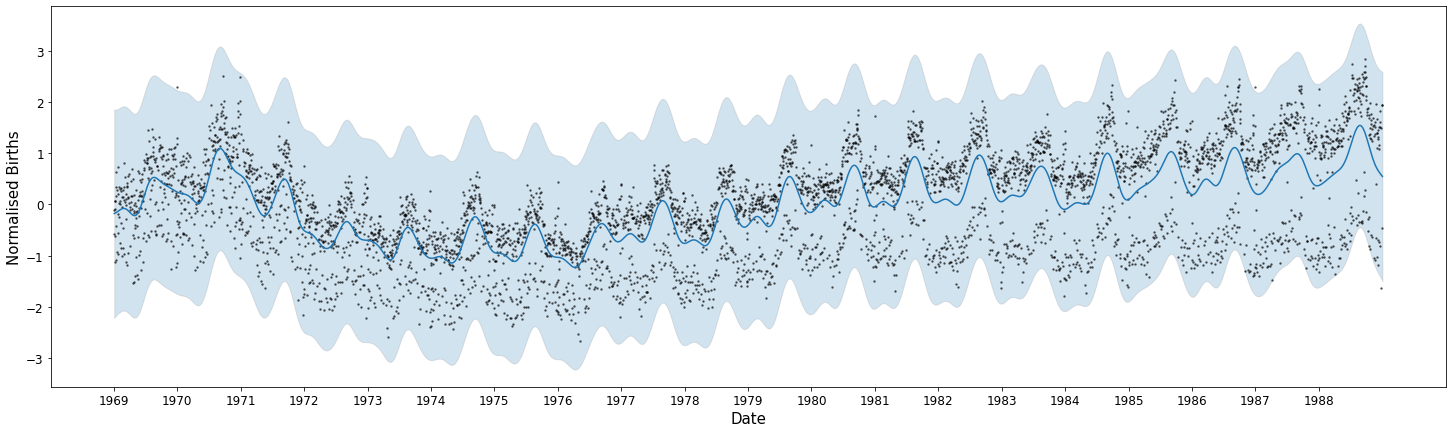

Test


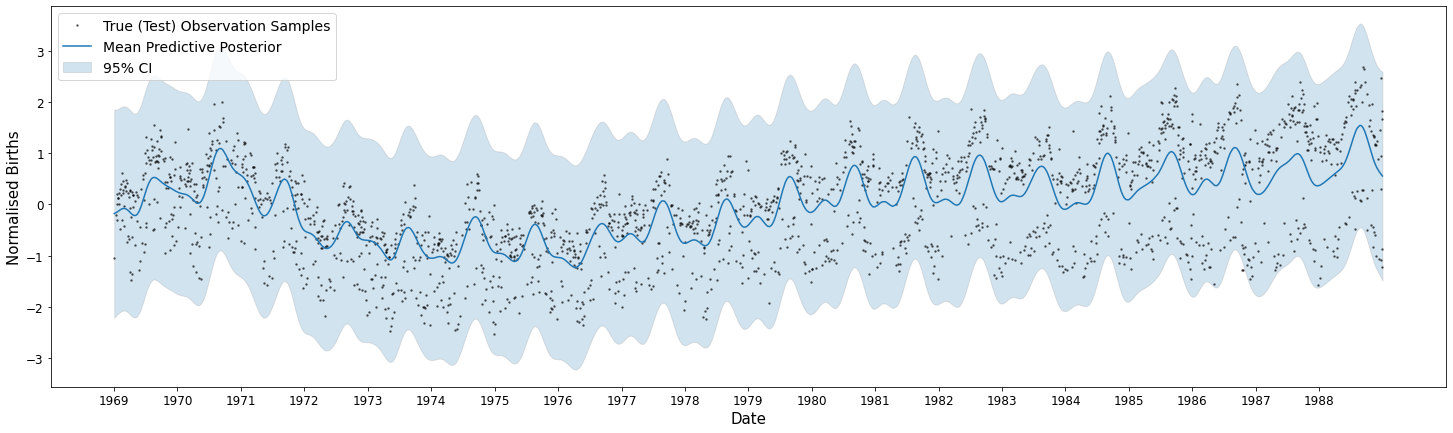

train ELBO, MSE, MAE:  -3749.0297112258972 0.5533335454464009 0.626638138470099
test ELBO, MSE, MAE:  -3802.5579564662075 0.5882293266787446 0.6454646588041508
percentage out of CI (train, test):  0.058673968316057104 0.09124087591240876
number out of CI (train, test):  3 2
Avg. CRPS (train, test):  0.4354142990688763 0.44707175072588257


--------------------------------------------------------
Starting Values l:  77
Train


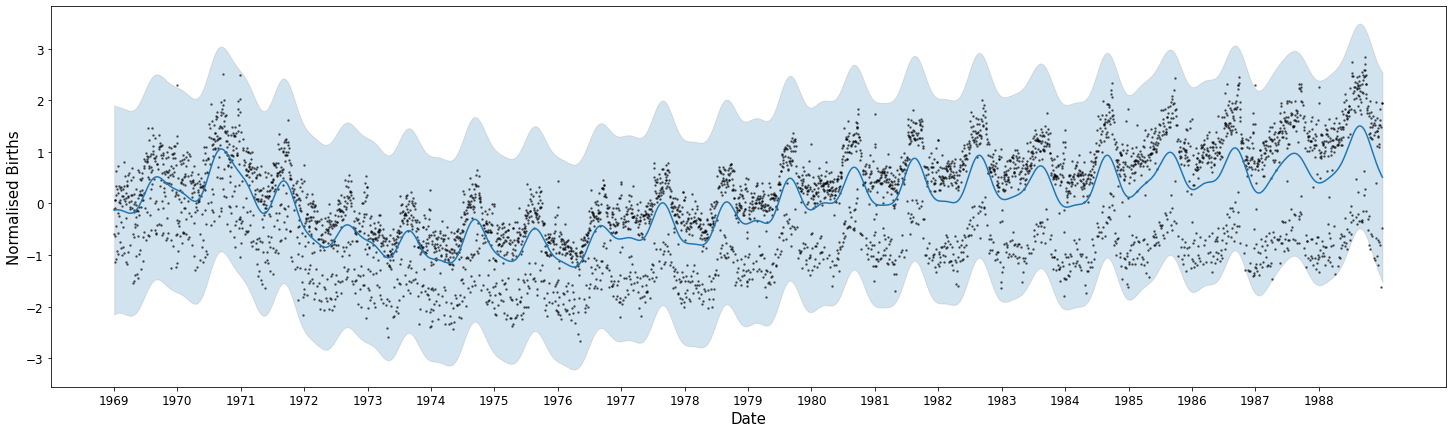

Test


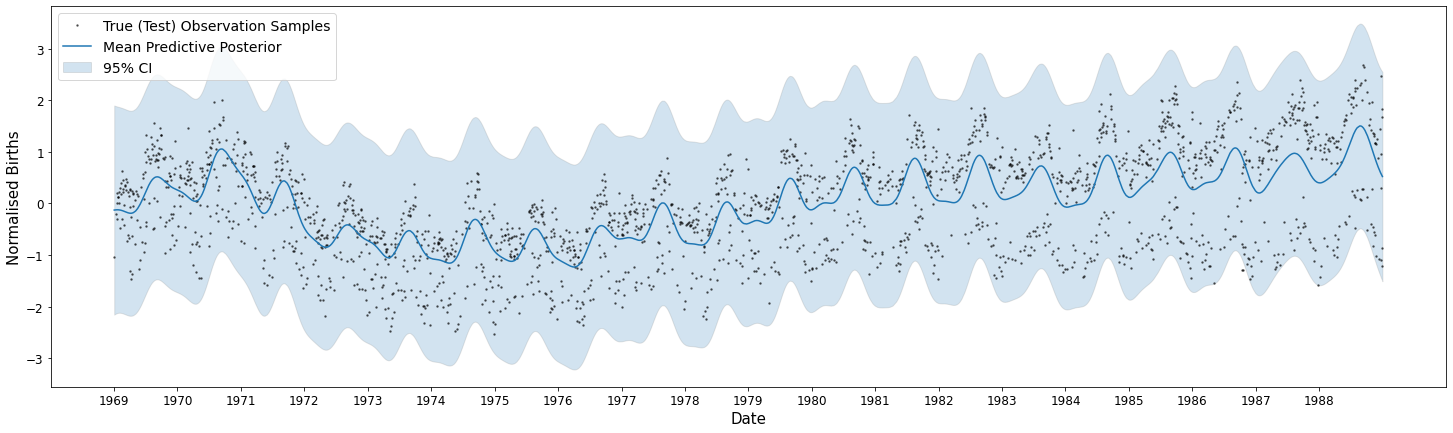

train ELBO, MSE, MAE:  -3729.8879900862107 0.5581325819341513 0.6285057954766757
test ELBO, MSE, MAE:  -3782.721209820479 0.5928676295800701 0.6477885587665575
percentage out of CI (train, test):  0.11734793663211421 0.13686131386861314
number out of CI (train, test):  6 3
Avg. CRPS (train, test):  0.43649657463765523 0.44818293492244315


--------------------------------------------------------
Starting Values l:  100
Train


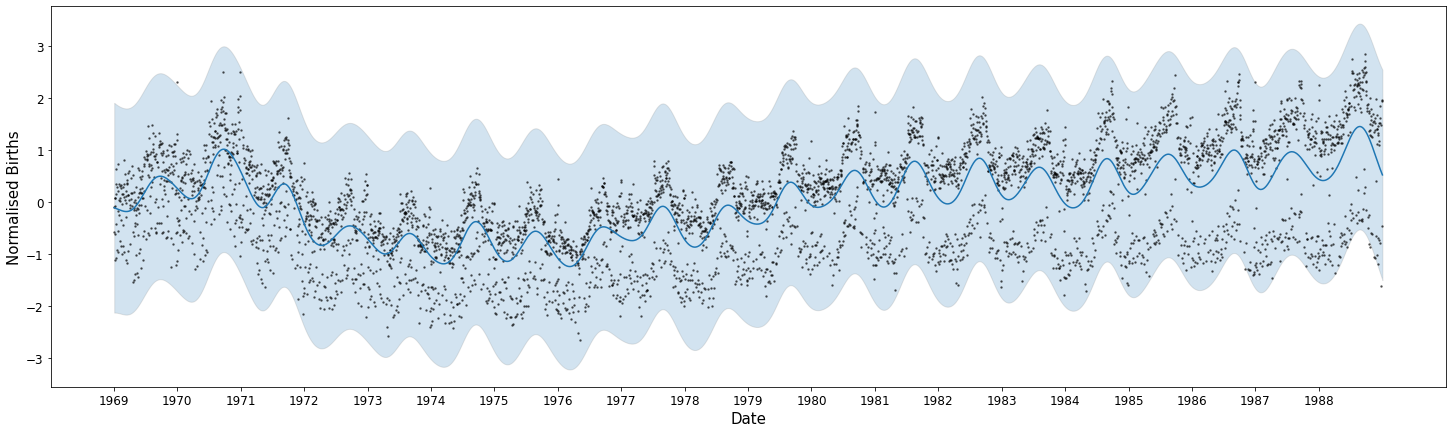

Test


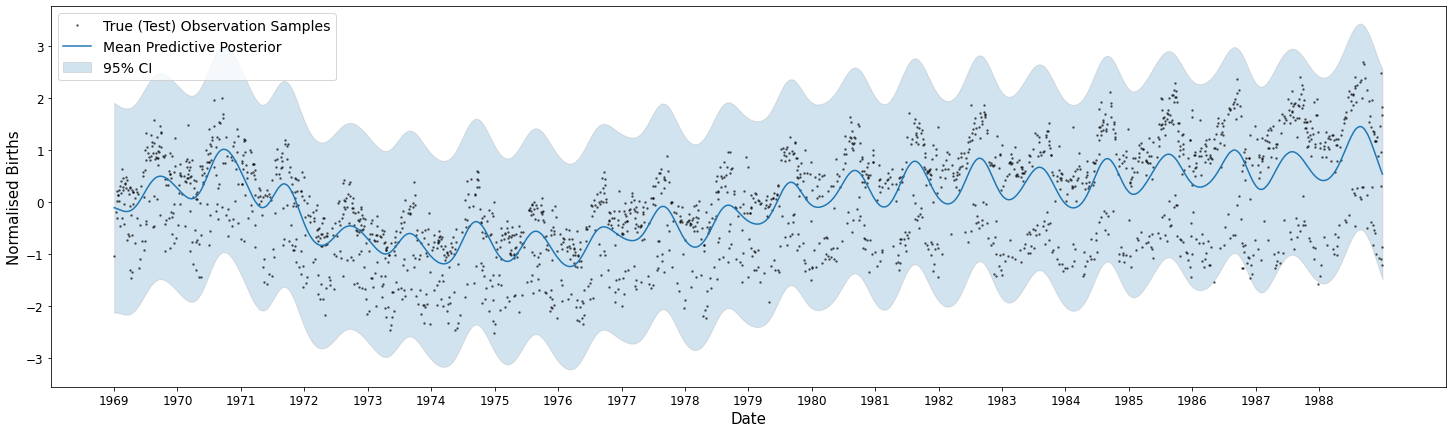

train ELBO, MSE, MAE:  -3727.7485975209593 0.5700288948523723 0.6328518794656517
test ELBO, MSE, MAE:  -3784.1152104403 0.6072554142488945 0.6536145680487268
percentage out of CI (train, test):  0.13690592607079993 0.18248175182481752
number out of CI (train, test):  7 4
Avg. CRPS (train, test):  0.44010751628298805 0.45271018747933267


--------------------------------------------------------
Starting Values l:  300
Train


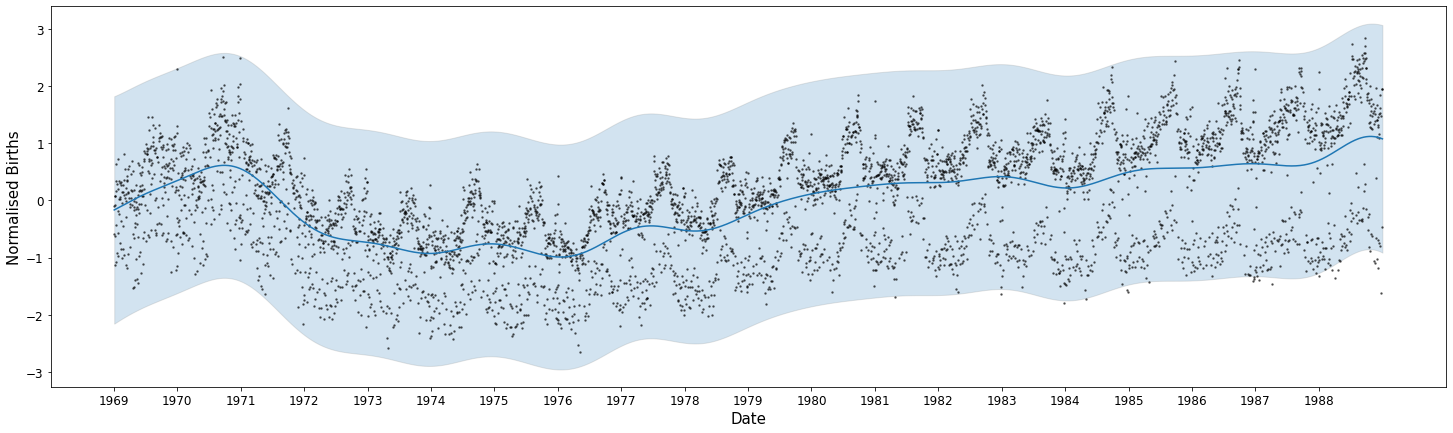

Test


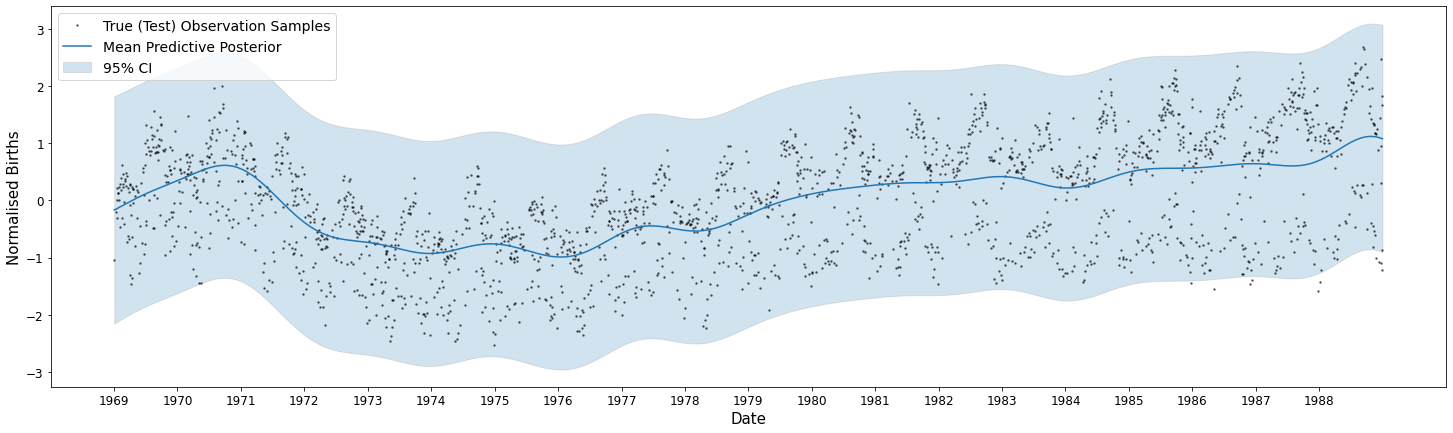

train ELBO, MSE, MAE:  -3781.6643773550254 0.6486496019341963 0.6539417183579662
test ELBO, MSE, MAE:  -3816.926952193273 0.6720537391517594 0.6664122032666642
percentage out of CI (train, test):  0.4302757676510855 0.5018248175182481
number out of CI (train, test):  22 11
Avg. CRPS (train, test):  0.4641702111674975 0.4721434497356252


--------------------------------------------------------


In [7]:
starting_values_l = [30, 50, 77, 100, 300]
M = 3000

for l in starting_values_l:
    print('Starting Values l: ', l)
    kernel = gpflow.kernels.RBF(lengthscales = l, variance = 1)
    Z = np.linspace(x_train.numpy().min(), x_train.numpy().max(), M)[:, None]
    model = gpflow.models.SVGP(kernel, gpflow.likelihoods.Gaussian(), Z, mean_function=gpflow.mean_functions.Zero(), num_data=M)
    set_trainable(model.likelihood.variance, False)
    
    model.kernel.lengthscales.prior = tfp.distributions.InverseGamma(to_default_float(1), to_default_float(1))
    model.kernel.variance.prior = tfp.distributions.Gamma(to_default_float(1), to_default_float(1))

    optimise_predict_model(model, epochs=50, alpha=0.1)
    print('--------------------------------------------------------')

______________________________________
____________________________________

Plots for write up

Train


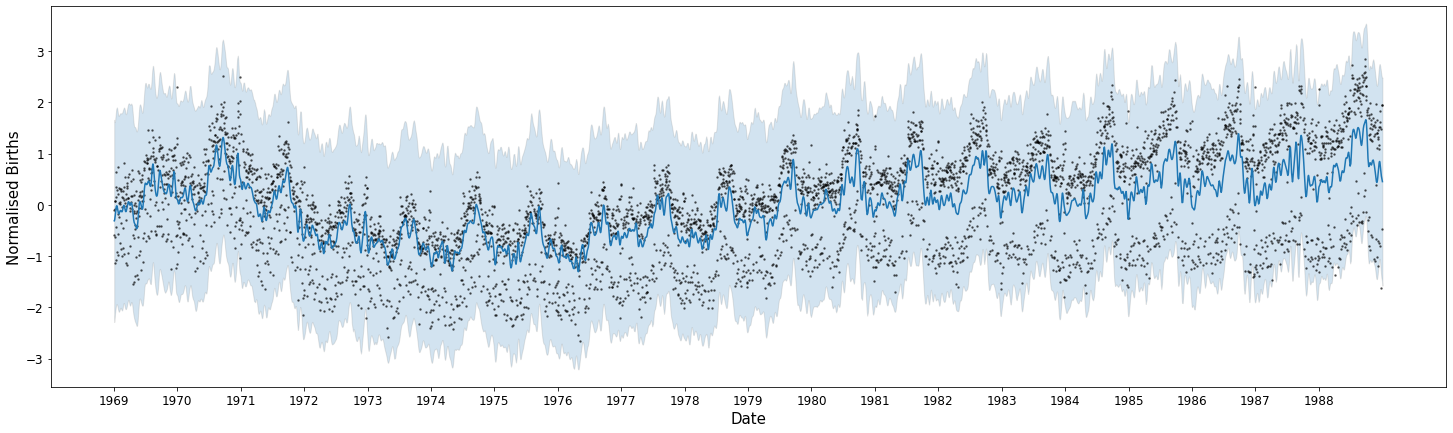

Test


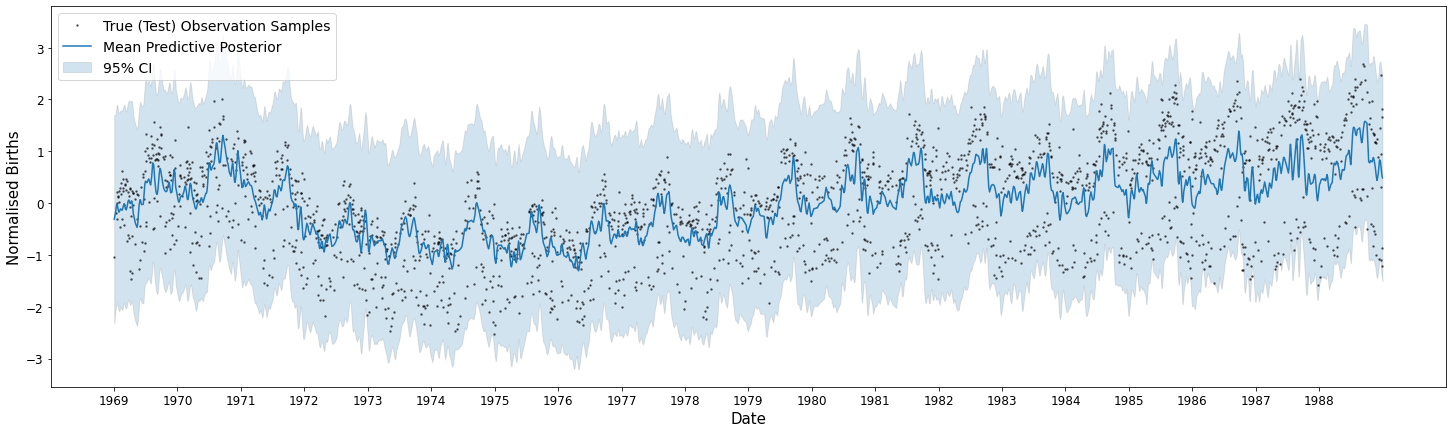

train ELBO, MSE, MAE:  -4045.610800700285 0.522276262657626 0.6068363469711624
test ELBO, MSE, MAE:  -4350.628768700853 0.6630641916366353 0.6860130294101394
percentage out of CI (train, test):  0.17602190494817133 0.2737226277372263
number out of CI (train, test):  9 6
Avg. CRPS (train, test):  0.42189564743132474 0.4703719407893198


: 

In [8]:
M = 3000
kernel = gpflow.kernels.RBF(lengthscales = 7, variance = 1)
Z = np.linspace(x_train.numpy().min(), x_train.numpy().max(), M)[:, None]
model = gpflow.models.SVGP(kernel, gpflow.likelihoods.Gaussian(), Z, mean_function=gpflow.mean_functions.Zero(), num_data=M)
set_trainable(model.likelihood.variance, True)

model.likelihood.variance.prior = tfp.distributions.Normal(to_default_float(0), to_default_float(1))
model.kernel.lengthscales.prior = tfp.distributions.InverseGamma(to_default_float(1), to_default_float(1))
model.kernel.variance.prior = tfp.distributions.Gamma(to_default_float(1), to_default_float(1))

optimise_predict_model(model, epochs=50)